In [1]:
import os
import dotenv
import duckdb

dotenv.load_dotenv()

CATALOG_NAME = "ffrd_catalog"
WAREHOUSE_NAME = "icedev"
BUCKET_NAME = "trinity-pilot"
CATALOG_ROOT = f"s3://{BUCKET_NAME}/{WAREHOUSE_NAME}"
TABLE_NAME_SPACE = "conformance"

# Credentials and connection info
POSTGRES_HOST = os.getenv("POSTGRES_HOST", "localhost")
POSTGRES_PORT = "5432"
POSTGRES_USER = os.getenv("POSTGRES_USER", "postgres")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD", "postgres")
POSTGRES_DB = os.getenv("POSTGRES_DB", "iceberg_catalog")
S3_BUCKET = BUCKET_NAME

S3_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
S3_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_REGION = os.getenv("AWS_REGION", "us-east-1")


def get_duckdb_connection():
    con = duckdb.connect(database=":memory:")
    # Install & load extensions
    con.execute("INSTALL httpfs;")
    con.execute("LOAD httpfs;")
    con.execute("INSTALL iceberg;")
    con.execute("LOAD iceberg;")
    con.execute(f"SET s3_access_key_id='{S3_ACCESS_KEY_ID}';")
    con.execute(f"SET s3_secret_access_key='{S3_SECRET_ACCESS_KEY}';")
    con.execute(f"SET s3_region='{S3_REGION}';")
    con.execute("SET s3_url_style='path';")
    con.execute(f"SET s3_use_ssl={'false'};")
    con.sql("INSTALL postgres_scanner;")
    con.sql("LOAD postgres_scanner;")

    pg_str = f"dbname={POSTGRES_DB} user={POSTGRES_USER} password={POSTGRES_PASSWORD} host={POSTGRES_HOST} port={POSTGRES_PORT}"
    return con, pg_str


def get_iceberg_table_metadata_location(con, pg_str):
    catalogs = con.sql(
        f"""
        SELECT *
        FROM postgres_scan(
            '{pg_str}',
            'public',
            'iceberg_tables'
        )
        LIMIT 10;
    """
    ).df()
    return catalogs

In [2]:
con, pg_str = get_duckdb_connection()

metadata_files = get_iceberg_table_metadata_location(con, pg_str)

hydra = metadata_files.iloc[1].metadata_location
hydro = metadata_files.iloc[0].metadata_location

print(hydra)
print(hydro)

s3://trinity-pilot/warehouse/conformance/hydraulics/metadata/00002-36c80633-2279-4c5d-9c8c-cc5315aad80b.metadata.json
s3://trinity-pilot/warehouse/conformance/hydrology/metadata/00001-1972370b-2420-47f2-89e0-0688754c2edf.metadata.json


In [11]:
HYDRO_SITE_ID = 'big-fossil-ck_j010'

hms_df = con.execute(
    f"""
    SELECT
        t0.event_id,
        t0.sim_time,
        t0.flow AS hms_flow
    FROM (
        SELECT * FROM iceberg_scan('{hydro}')
    ) AS t0
    WHERE t0.site_id = '{HYDRO_SITE_ID}'
      AND t0.event_id = 4
    ORDER BY t0.event_id, t0.sim_time
    ASC
    """
).fetchdf()

hms_df.head()

,event_id,sim_time,hms_flow
0,4,1995-10-11 00:00:00,0.0
1,4,1995-10-11 01:00:00,0.0
2,4,1995-10-11 02:00:00,0.0
3,4,1995-10-11 03:00:00,0.0
4,4,1995-10-11 04:00:00,0.0


<Axes: title={'center': 'HMS Flow at Site big-fossil-ck_j010'}, xlabel='sim_time'>

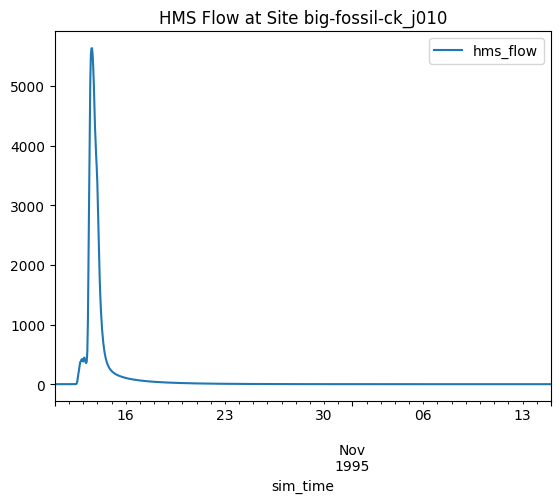

In [12]:
hms_df.plot(x='sim_time', y=['hms_flow'], kind='line', title=f'HMS Flow at Site {HYDRO_SITE_ID}')

In [13]:
HYDRA_SITE_ID = 'gage_usgs_08048800_big-fossil-ck'

ras_df = con.execute(
    f"""
    SELECT
        t1.event_id,
        t1.sim_time,
        t1.flow AS ras_flow
    FROM (
        SELECT * FROM iceberg_scan('{hydra}')
    ) AS t1
    WHERE t1.site_id = '{HYDRA_SITE_ID}'
      AND t1.event_id = 4
    ORDER BY t1.event_id, t1.sim_time
    """
).fetchdf()

ras_df.head()

,event_id,sim_time,ras_flow
0,4,1992-11-22 00:00:00,0.0
1,4,1992-11-22 01:00:00,0.0
2,4,1992-11-22 02:00:00,0.0
3,4,1992-11-22 03:00:00,0.0
4,4,1992-11-22 04:00:00,0.0


<Axes: title={'center': 'RAS Stage at Site gage_usgs_08048800_big-fossil-ck'}, xlabel='sim_time'>

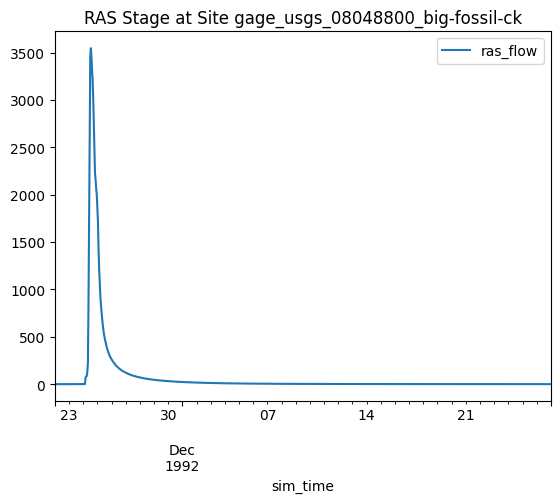

In [ ]:
ras_df.plot(x='sim_time', y=['ras_flow'], kind='line', title=f'RAS Flow at Site {HYDRA_SITE_ID}')

In [16]:
HYDRO_SITE_ID = 'big-fossil-ck_j010'
HYDRA_SITE_ID = 'gage_usgs_08048800_big-fossil-ck'

df = con.execute(
    f"""
    SELECT
        t0.event_id,
        t0.sim_time as hms_sim_time,
        t1.sim_time as ras_sim_time,
        t0.flow AS hms_flow,
        t1.stage AS ras_stage
    FROM (
        SELECT * FROM iceberg_scan('{hydro}')
    ) AS t0
    JOIN (
        SELECT * FROM iceberg_scan('{hydra}')
    ) AS t1
        ON t0.event_id = t1.event_id
    WHERE t0.site_id = '{HYDRO_SITE_ID}'
      AND t1.site_id = '{HYDRA_SITE_ID}'
      AND t0.event_id = 4
    ORDER BY t0.event_id, t0.sim_time
    """
).fetchdf()

df.head()


,event_id,hms_sim_time,ras_sim_time,hms_flow,ras_stage
0,4,1995-10-11,1992-12-27 00:00:00,0.0,486.652313
1,4,1995-10-11,1992-12-26 23:00:00,0.0,486.652374
2,4,1995-10-11,1992-12-26 22:00:00,0.0,486.652435
3,4,1995-10-11,1992-12-26 21:00:00,0.0,486.652527
4,4,1995-10-11,1992-12-26 20:00:00,0.0,486.652588
